In [24]:
import random

import cv2
from matplotlib import pyplot as plt
import json
from PIL import Image
import numpy as np 

import albumentations as A

In [45]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)
    
    
def boxCreate(points):
    
    x_min = min(points[0][0], points[1][0])
    y_min = min(points[0][1], points[1][1])
    x_max = max(points[0][0], points[1][0])
    y_max = max(points[0][1], points[1][1])

    width = x_max - x_min
    height = y_max - y_min

    return [x_min, y_min, width, height]


def bbox_to_coords(bbox):
    
    x_min, y_min, width, height = bbox
    x_max = x_min + width
    y_max = y_min + height
    
    return [[x_max, y_max],[x_min, y_min]]


def load_json(json_file_path):
    with open(json_file_path, "r") as f:
        return json.load(f)

def shapes_element_maker(transformed, category_id_to_name):
    shapes = []
    for bbox, category_id in zip(transformed['bboxes'], transformed['category_ids']):
        subdict = {
            "label": category_id_to_name[category_id],
            "points": bbox_to_coords(bbox),
            "group_id": 'null',
            "description": "",
            "shape_type": "rectangle",
            "flags": {},
            "mask": 'null'
        }
        shapes.append(subdict)
    return shapes

def save_json(json_dict, json_file_path):
    with open(json_file_path, 'w') as json_file:
        json.dump(json_dict, json_file)


In [26]:
image = cv2.imread('../Database_Whole/Database/tile_4_90.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

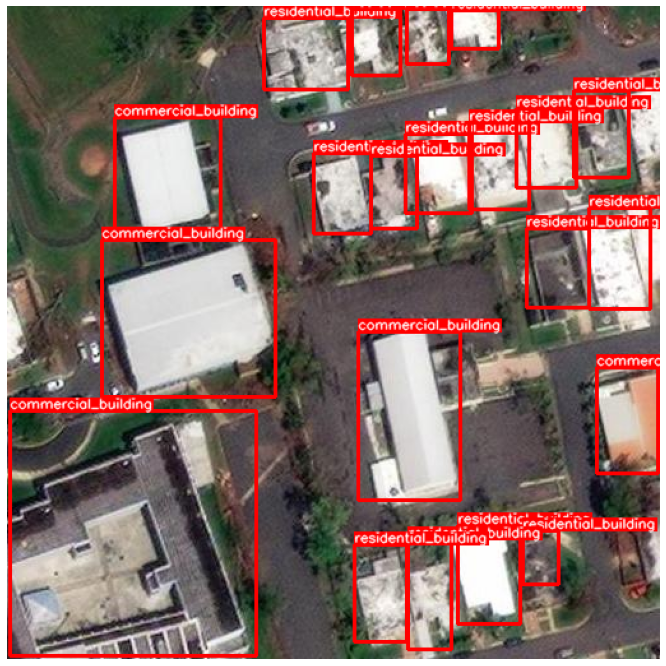

In [28]:
json_file_path = "../Database_Whole/Database/tile_4_90.json"

# Open the JSON file and load its contents
with open(json_file_path, "r") as f:
    data = json.load(f)

bboxes = []
category_ids = []

category_name_to_id = {'commercial_building':1, 'residential_building':2}
category_id_to_name = {1:'commercial_building', 2:'residential_building'}


for i in range(len(data['shapes'])):
    
    label = data['shapes'][i]['label']
    shape = data['shapes'][i]['points']
    
    category_ids.append(category_name_to_id[label])
    bboxes.append(boxCreate(shape))
    
    
visualize(image, bboxes, category_ids, category_id_to_name)

## Create the Transformation and the Json file. 

In [31]:
# Load your image (replace 'your_image.jpg' with your image path)
image = Image.open('../Database_Whole/Database/tile_4_90.jpg')
json_file_path = "../Database_Whole/Database/tile_4_90.json"


# Open the JSON file and load its contents
with open(json_file_path, "r") as f:
    data = json.load(f)

bboxes = []
category_ids = []

category_name_to_id = {'commercial_building':1, 'residential_building':2} # To be given as input
category_id_to_name = {1:'commercial_building', 2:'residential_building'} # To be given as input


for i in range(len(data['shapes'])):
    
    label = data['shapes'][i]['label']
    shape = data['shapes'][i]['points']
    
    category_ids.append(category_name_to_id[label])
    bboxes.append(boxCreate(shape))

In [37]:

transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.PadIfNeeded(min_height=image.size[1], min_width=image.size[0], border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0))],
    bbox_params=A.BboxParams(format='coco', label_fields=['category_ids'])
    )


image_np = np.array(image)

# Apply the transformation
transformed = transform(image=image_np, bboxes=bboxes, category_ids=category_ids)

In [38]:

# Get the transformed image
transformed_image = transformed['image']

# Convert NumPy array back to PIL Image
transformed_image_pil = Image.fromarray(transformed_image)

# Save the transformed image (replace 'transformed_image.jpg' with your desired filename)
transformed_image_pil.save("transformed_image.jpg")

In [41]:
json_dict = {
    "version": "5.4.1",
    "flags": {},
    "shapes": []
}


def shapesElementMaker(transformed):
    shapes = []
    
    for bbox, category_id in zip(transformed['bboxes'], transformed['category_ids']):
        subdict = {
            "label": category_id_to_name[category_id],
            "points": bbox_to_coords(bbox),
            "group_id": 'null',
            "description": "",
            "shape_type": "rectangle",
            "flags": {},
            "mask": 'null'
        }
        shapes.append(subdict)
    
    return shapes

json_dict["shapes"] = shapesElementMaker(transformed= transformed)

with open('json_transformed.json', 'w') as json_file:
    json.dump(json_dict, json_file)

## Open the Pic

In [42]:
image = cv2.imread('./transformed_image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [48]:
json_file_path = "json_transformed.json"

# Open the JSON file and load its contents
with open(json_file_path, "r") as f:
    data = json.load(f)

bboxes = []
category_ids = []

category_name_to_id = {'commercial_building':1, 'residential_building':2}
category_id_to_name = {1:'commercial_building', 2:'residential_building'}


for i in range(len(data['shapes'])):
    
    label = data['shapes'][i]['label']
    shape = data['shapes'][i]['points']
    
    category_ids.append(category_name_to_id[label])
    bboxes.append(boxCreate(shape))

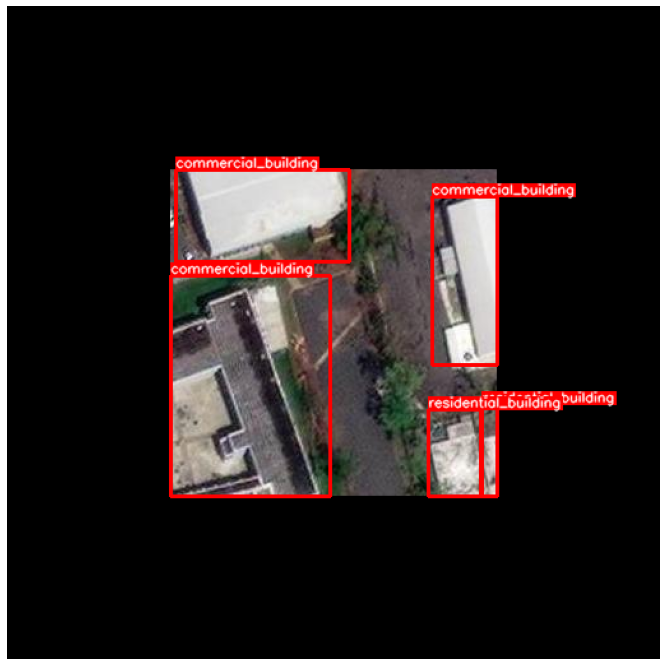

In [44]:
visualize(image, bboxes, category_ids, category_id_to_name)

## A bit better Code

In [47]:

# Define your image path and json file path
image_path = '../Database_Whole/Database/tile_4_90.jpg'
json_file_path = "../Database_Whole/Database/tile_4_90.json"

# Load your image
image = Image.open(image_path)

# Load JSON data
data = load_json(json_file_path)

# Extract bounding boxes and category ids
bboxes = []
category_ids = []
category_name_to_id = {'commercial_building': 1, 'residential_building': 2}  # To be given as input
category_id_to_name = {1: 'commercial_building', 2: 'residential_building'}  # To be given as input

for shape in data['shapes']:
    label = shape['label']
    points = shape['points']
    category_ids.append(category_name_to_id[label])
    bboxes.append(boxCreate(points))

# Define transformation pipeline
transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.PadIfNeeded(min_height=image.height, min_width=image.width, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0))],
    bbox_params=A.BboxParams(format='coco', label_fields=['category_ids'])
)

# Convert image to numpy array
image_np = np.array(image)

# Apply the transformation
transformed = transform(image=image_np, bboxes=bboxes, category_ids=category_ids)

# Get the transformed image
transformed_image = transformed['image']

# Convert NumPy array back to PIL Image
transformed_image_pil = Image.fromarray(transformed_image)

# Save the transformed image
transformed_image_pil.save("transformed_image.jpg")

# Create JSON dictionary for transformed data
json_dict = {"version": "5.4.1", "flags": {}, "shapes": shapes_element_maker(transformed, category_id_to_name)}

# Save transformed data to JSON file
save_json(json_dict, 'json_transformed.json')


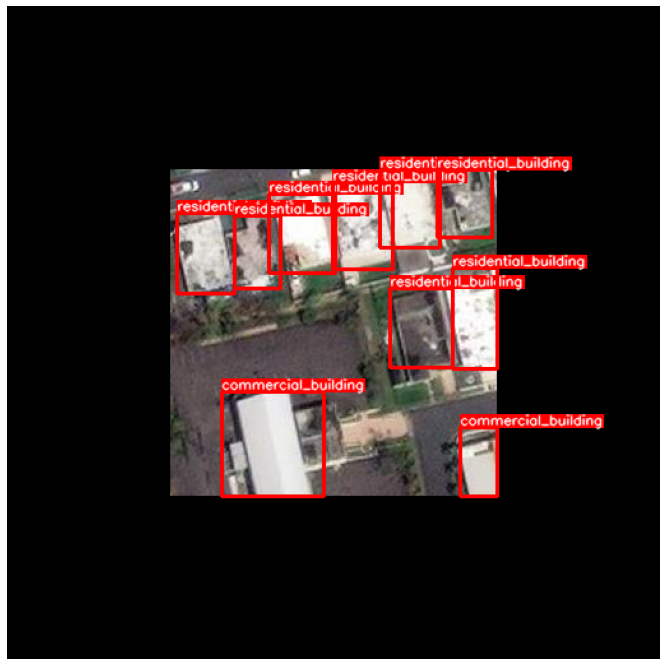

In [49]:
image = cv2.imread('./transformed_image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

json_file_path = "json_transformed.json"

# Open the JSON file and load its contents
with open(json_file_path, "r") as f:
    data = json.load(f)

bboxes = []
category_ids = []

category_name_to_id = {'commercial_building':1, 'residential_building':2}
category_id_to_name = {1:'commercial_building', 2:'residential_building'}


for i in range(len(data['shapes'])):
    
    label = data['shapes'][i]['label']
    shape = data['shapes'][i]['points']
    
    category_ids.append(category_name_to_id[label])
    bboxes.append(boxCreate(shape))
    
visualize(image, bboxes, category_ids, category_id_to_name)